In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Computer Vision Project

## Distraction detection during driving

The main goal of this notebook is to show how can we detect the distraction of a driver using a dataset of thousand of driver images.
More precisely we want to classify the activity the driver is performing (driving, texting, talking, operating the radio etc)

### Table of Contents

* [Part 1 : Loading Dataset ](#chapter1)
    
* [Part 2 : EDA](#chapter2)

* [Part 3 : Performing a CNN model for classification](#chapter3)

* [Part 4 : Data augmentation for increase robustness](#chapter4)

* [Part 5 : Transfer Learning for increasing accuracy](#chapter4)

### Technology used :
- Python libraries : OpenCV, Tenserflow, Scikit Learn, Pandas,...
- Computer vision techniques : CNN, Data Augmentation, Transfer Learning

## Dataset sample

The initial Dataset is composed of a thousand of images labelized as above. The goal of this notebook is to show how to classify them using computer vision techniques

## Some check about libraries

In [ ]:
import zipfile
import random
import Augmentor

def unzip_file(zip_path):
    # Get the base name of the zip file (excluding the extension)
    base_name = os.path.splitext(os.path.basename(zip_path))[0]

    # Create a folder with the same name as the zip file
    output_folder = os.path.join(os.path.dirname(zip_path), base_name)
    os.makedirs(output_folder, exist_ok=True)

    # Extract the contents of the zip file to the folder
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)
    return output_folder

def augment_images_in_folder(input_folder, output_folder, num_of_augment_img):
    # Create an Augmentor pipeline for the current image
    pipeline = Augmentor.Pipeline(input_folder, output_directory=output_folder)

    # Add augmentations to the pipeline
    pipeline.flip_left_right(probability=0.8)
    pipeline.shear(probability=0.5, max_shear_left=15, max_shear_right=15)
    pipeline.rotate(probability=0.5, max_left_rotation=20, max_right_rotation=20)

    pipeline.random_brightness(probability=0.2, min_factor=0.5, max_factor=1.5)
    pipeline.random_contrast(probability=0.2, min_factor=0.5, max_factor=1.5)
    pipeline.random_color(probability=0.2, min_factor=0.5, max_factor=1.5)

    pipeline.skew(probability=0.5)
    pipeline.histogram_equalisation(probability=0.5)

    pipeline.sample(num_of_augment_img)
    pipeline.augmentor_images.clear()

def unzip_and_augment(zipped_file_path, num_of_augment_img):
    if not os.path.isfile(zipped_file_path):
        file_path = zipped_file_path
    else:
        file_path = unzip_file(zipped_file_path)

    train_folder_path = os.path.join(file_path, "train")
    for subfolder_name in os.listdir(train_folder_path):
        subfolder_path = os.path.join(train_folder_path, subfolder_name)
        # Check if the current item in the directory is a directory itself
        if os.path.isdir(subfolder_path):
            # Create an output path for the augmented images
            output_path = os.path.join('../', subfolder_name)

            # Call the function to augment images in the current subfolder
            augment_images_in_folder(subfolder_path, output_path, num_of_augment_img)

file_path = os.path.join('imgs')

num_of_augment_img = 250

unzip_and_augment(file_path, num_of_augment_img)

Initialised with 3345 image(s) found.
Output directory set to imgs\train\c0\../c0.

Processing <PIL.Image.Image image mode=RGB size=480x640 at 0x1EDF0C89910>: 100%|█| 250/250 [00:03<00:00, 65.84 Samples/


Initialised with 2777 image(s) found.
Output directory set to imgs\train\c1\../c1.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF07A6970>: 100%|█| 250/250 [00:03<00:00, 67.38 Samples/


Initialised with 2317 image(s) found.
Output directory set to imgs\train\c2\../c2.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF0681EB0>: 100%|█| 250/250 [00:03<00:00, 66.74 Samples/


Initialised with 2356 image(s) found.
Output directory set to imgs\train\c3\../c3.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF07C9A60>: 100%|█| 250/250 [00:03<00:00, 68.91 Samples/


Initialised with 2336 image(s) found.
Output directory set to imgs\train\c4\../c4.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF069A070>: 100%|█| 250/250 [00:03<00:00, 69.88 Samples/


Initialised with 2322 image(s) found.
Output directory set to imgs\train\c5\../c5.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF07AAC10>: 100%|█| 250/250 [00:03<00:00, 66.83 Samples/


Initialised with 2335 image(s) found.
Output directory set to imgs\train\c6\../c6.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF069B910>: 100%|█| 250/250 [00:03<00:00, 67.15 Samples/


Initialised with 2012 image(s) found.
Output directory set to imgs\train\c7\../c7.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF096DB80>: 100%|█| 250/250 [00:04<00:00, 62.00 Samples/


Initialised with 1921 image(s) found.
Output directory set to imgs\train\c8\../c8.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF06B94F0>: 100%|█| 250/250 [00:03<00:00, 74.13 Samples/


Initialised with 2139 image(s) found.
Output directory set to imgs\train\c9\../c9.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x1EDF080B910>: 100%|█| 250/250 [00:03<00:00, 66.77 Samples/


## Part 1 : Loading Dataset  <a class="anchor" id="chapter1"></a>

In [ ]:
import os
from glob import glob
import random
import time
import tensorflow as tf
import datetime
#os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16


dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [ ]:
# Groupby subjects
by_drivers = dataset.groupby('subject')
# Groupby unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(dataset.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


### Some functions for loading and normalization

The 10 classes to classify are :
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

In [ ]:
NUMBER_CLASSES = 10 # 10 classes
img_rows = 64 # dimension of images
img_cols = 64
batch_size = 40

In [ ]:
# Read with opencv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = []
    train_labels = []
    # Loop over the training folder
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        print("classed values is",classed)
        path_pattern = os.path.join('imgs', 'train', 'c' + str(classed), '*.jpg')
        #print("path pattern is",path_pattern)
        files = glob(path_pattern)
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, 10) #categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    #path = os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg')
    path = os.path.join('imgs', 'test', '*.jpg')

    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [ ]:
color_type = 1 # grey
nb_test_samples = 500

# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading directory c0
classed values is 0



 10%|████████▎                                                                          | 1/10 [00:05<00:50,  5.63s/it]

Loading directory c1
classed values is 1



 20%|████████████████▌                                                                  | 2/10 [00:10<00:41,  5.15s/it]

Loading directory c2
classed values is 2



 30%|████████████████████████▉                                                          | 3/10 [00:14<00:31,  4.52s/it]

Loading directory c3
classed values is 3



 40%|█████████████████████████████████▏                                                 | 4/10 [00:17<00:25,  4.20s/it]

Loading directory c4
classed values is 4



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:21<00:20,  4.09s/it]

Loading directory c5
classed values is 5



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:25<00:16,  4.02s/it]

Loading directory c6
classed values is 6



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:29<00:11,  3.95s/it]

Loading directory c7
classed values is 7



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:33<00:07,  3.83s/it]

Loading directory c8
classed values is 8



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:36<00:03,  3.73s/it]

Loading directory c9
classed values is 9


  1%|▍                                                                            | 500/79726 [00:00<02:19, 568.33it/s]


In [ ]:
color_type = 3 # color

# loading train images
x_trainRGB, x_testRGB, y_trainRGB, y_testRGB = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_filesRGB, test_targetsRGB = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading directory c0
classed values is 0



 10%|████████▎                                                                          | 1/10 [00:08<01:15,  8.41s/it]

Loading directory c1
classed values is 1



 20%|████████████████▌                                                                  | 2/10 [00:15<01:02,  7.75s/it]

Loading directory c2
classed values is 2



 30%|████████████████████████▉                                                          | 3/10 [00:21<00:48,  7.00s/it]

Loading directory c3
classed values is 3



 40%|█████████████████████████████████▏                                                 | 4/10 [00:28<00:40,  6.71s/it]

Loading directory c4
classed values is 4



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:34<00:33,  6.62s/it]

Loading directory c5
classed values is 5



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:40<00:25,  6.43s/it]

Loading directory c6
classed values is 6



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:46<00:18,  6.27s/it]

Loading directory c7
classed values is 7



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:52<00:12,  6.17s/it]

Loading directory c8
classed values is 8



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:57<00:05,  5.88s/it]

Loading directory c9
classed values is 9


  1%|▍                                                                            | 500/79726 [00:01<03:16, 402.98it/s]


In [ ]:
x_train_gray3 = np.repeat(x_train, 3, axis=-1)
x_test_gray3 = np.repeat(x_test, 3, axis=-1)

train_generator_grayscale = ImageDataGenerator(validation_split = 0.2)
test_generator_grayscale = ImageDataGenerator()
train_generator_color = ImageDataGenerator(validation_split = 0.2)
test_generator_color = ImageDataGenerator()

grayscale3_train = train_generator_grayscale.flow(x_train_gray3, y_train, batch_size=batch_size, subset='training')
grayscale3_val = train_generator_grayscale.flow(x_train_gray3, y_train, batch_size=batch_size, subset='validation')
grayscale3_test = test_generator_grayscale.flow(x_test_gray3, y_test, batch_size=batch_size)

rgb_train = train_generator_color.flow(x_trainRGB, y_trainRGB, batch_size=batch_size, subset='training')
rgb_val = train_generator_color.flow(x_trainRGB, y_trainRGB, batch_size=batch_size, subset='validation')
rgb_test = test_generator_color.flow(x_testRGB, y_testRGB, batch_size=batch_size)

## Part 2 : EDA  <a class="anchor" id="chapter2"></a>

### Data visualisation

Number of images by category

In [ ]:
x_train.shape

(21088, 64, 64, 1)

In [ ]:
import plotly.express as px
px.histogram(dataset, x="classname", color="classname", title="Number of images by categories ")

--> It is well distributed

In [ ]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

### Images overview

Let's take a look at the various images in the dataset.
* I'll plot an image for each of the 10 classes.

In [ ]:
activity_map = {'c0': 'Safe driving',
                'c1': 'Texting - right',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting - left',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

#../input/state-farm-distracted-driver-detection/imgs/train/

plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = './imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [ ]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [ ]:
def create_callbacks(model_path):
    checkpointer = ModelCheckpoint(filepath=model_path,
                                   monitor='val_loss', mode='min',
                                   verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    callbacks = [checkpointer, es]
    return callbacks

In [ ]:
from sklearn.metrics import f1_score
import tensorflow_addons as tfa
f1 = tfa.metrics.F1Score(10, 'micro')

In [ ]:
def eval_model(model, model_path, test_generator):
    model.load_weights(model_path)
    score = model.evaluate(test_generator, verbose=1)
    print(score)
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])
    print("Test micro-f1 Score:", score[2])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def generate_confusion_matrix(model, model_path, test_generator, class_labels):
    # Load the best weights
    model.load_weights(model_path)

    # Predict the classes for the test set
    y_pred = model.predict_generator(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get the true classes indirectly by iterating over the generator
    y_true_classes = []
    num_batches = len(test_generator)
    for i in range(num_batches):
        _, batch_true_classes = test_generator[i]
        y_true_classes.extend(np.argmax(batch_true_classes, axis=1))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Get class labels
NUMBER_CLASSES = 10
class_labels = [f'c{i}' for i in range(NUMBER_CLASSES)]


## Part 3 : CNN Models  <a class="anchor" id="chapter3"></a>

**Custom model**

Architecture :
- 3 Convolutionnal layers (with Relu, Maxpooling and dropout)
- A flatten layer
- 2 Dense layers with Relu and Dropouts
- 1 Dense layer with softmax for the classification

In [ ]:
# Base learning rate
base_lr = 0.001
# number of epochs
nb_epoch = 10

In [ ]:
def create_custom_conv_net(img_rows,img_cols,color_type):
    model = Sequential()
    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(64, (3, 3), activation='relu'))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

Epoch 1/10
419/422 [============================>.] - ETA: 0s - loss: 1.6116 - accuracy: 0.6424 - f1_score: 0.6424
Epoch 1: val_loss improved from inf to 0.50620, saving model to ./saved_models\customcnn_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


422/422 [==============================] - 7s 13ms/step - loss: 1.6068 - accuracy: 0.6429 - f1_score: 0.6429 - val_loss: 0.5062 - val_accuracy: 0.8421 - val_f1_score: 0.8421
Epoch 2/10
419/422 [============================>.] - ETA: 0s - loss: 0.4148 - accuracy: 0.8682 - f1_score: 0.8682
Epoch 2: val_loss improved from 0.50620 to 0.46201, saving model to ./saved_models\customcnn_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


422/422 [==============================] - 4s 10ms/step - loss: 0.4156 - accuracy: 0.8681 - f1_score: 0.8681 - val_loss: 0.4620 - val_accuracy: 0.8606 - val_f1_score: 0.8606
Epoch 3/10
417/422 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8944 - f1_score: 0.8944
Epoch 3: val_loss improved from 0.46201 to 0.45957, saving model to ./saved_models\customcnn_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


422/422 [==============================] - 4s 10ms/step - loss: 0.3149 - accuracy: 0.8944 - f1_score: 0.8944 - val_loss: 0.4596 - val_accuracy: 0.8684 - val_f1_score: 0.8684
Epoch 4/10
421/422 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.9096 - f1_score: 0.9096
Epoch 4: val_loss did not improve from 0.45957
422/422 [==============================] - 4s 8ms/step - loss: 0.2686 - accuracy: 0.9095 - f1_score: 0.9095 - val_loss: 0.5014 - val_accuracy: 0.8670 - val_f1_score: 0.8670
Epoch 5/10
417/422 [============================>.] - ETA: 0s - loss: 0.2169 - accuracy: 0.9265 - f1_score: 0.9265
Epoch 5: val_loss did not improve from 0.45957
422/422 [==============================] - 4s 8ms/step - loss: 0.2168 - accuracy: 0.9266 - f1_score: 0.9266 - val_loss: 0.5428 - val_accuracy: 0.8700 - val_f1_score: 0.8700
Epoch 6/10
422/422 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.9274 - f1_score: 0.9274
Epoch 6: val_loss did not improve from 0.

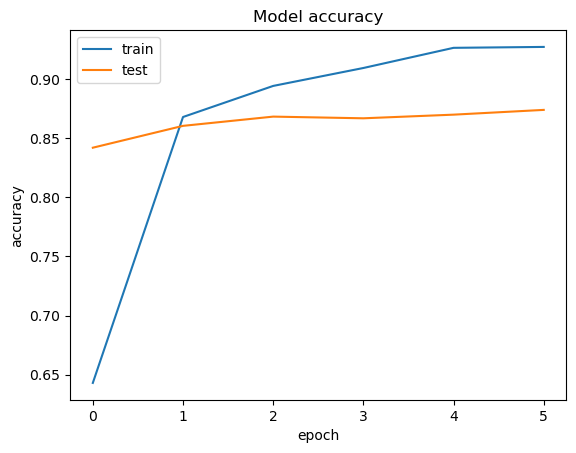

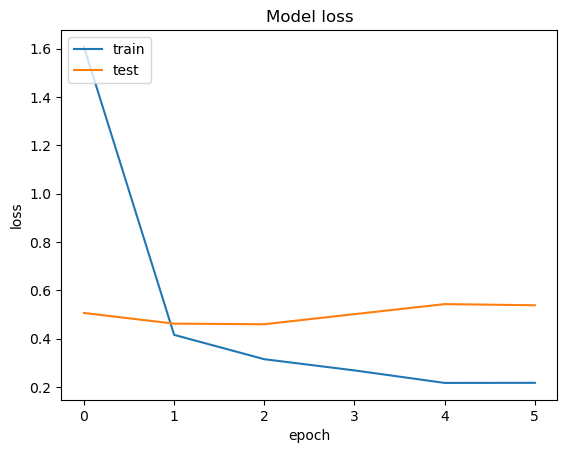

132/132 [==============================] - 1s 5ms/step - loss: 0.4637 - accuracy: 0.8596 - f1_score: 0.8596
[0.46365082263946533, 0.8596358299255371, 0.8596358299255371]
Test Loss: 0.46365082263946533
Test Accuracy: 0.8596358299255371
Test micro-f1 Score: 0.8596358299255371


In [ ]:
model = create_custom_conv_net(img_rows,img_cols,1)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy', metrics=['accuracy', f1])
# Create model checkpoint and earlystopper
model_path = './saved_models/customcnn_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale_cnn = model.fit(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_grayscale_cnn)
eval_model(model, model_path, grayscale3_test)

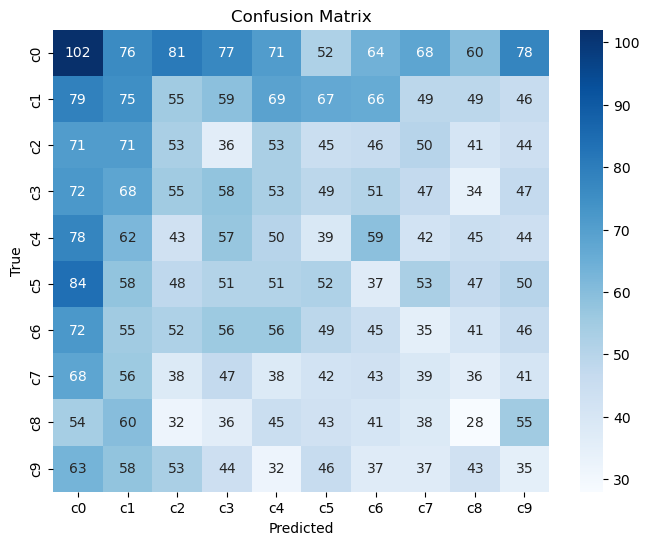

In [ ]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
421/422 [============================>.] - ETA: 0s - loss: 1.6683 - accuracy: 0.6575 - f1_score: 0.7057
Epoch 1: val_loss improved from inf to 0.56289, saving model to ./saved_models\customcnn_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


422/422 [==============================] - 5s 11ms/step - loss: 1.6658 - accuracy: 0.6580 - f1_score: 0.7060 - val_loss: 0.5629 - val_accuracy: 0.8286 - val_f1_score: 0.8286
Epoch 2/10
416/422 [============================>.] - ETA: 0s - loss: 0.4300 - accuracy: 0.8647 - f1_score: 0.8647
Epoch 2: val_loss improved from 0.56289 to 0.44634, saving model to ./saved_models\customcnn_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


422/422 [==============================] - 4s 10ms/step - loss: 0.4306 - accuracy: 0.8646 - f1_score: 0.8646 - val_loss: 0.4463 - val_accuracy: 0.8658 - val_f1_score: 0.8658
Epoch 3/10
420/422 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8970 - f1_score: 0.8970
Epoch 3: val_loss improved from 0.44634 to 0.44244, saving model to ./saved_models\customcnn_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


422/422 [==============================] - 5s 11ms/step - loss: 0.3124 - accuracy: 0.8968 - f1_score: 0.8968 - val_loss: 0.4424 - val_accuracy: 0.8708 - val_f1_score: 0.8708
Epoch 4/10
419/422 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9185 - f1_score: 0.9185
Epoch 4: val_loss did not improve from 0.44244
422/422 [==============================] - 4s 9ms/step - loss: 0.2419 - accuracy: 0.9184 - f1_score: 0.9184 - val_loss: 0.4787 - val_accuracy: 0.8679 - val_f1_score: 0.8679
Epoch 5/10
419/422 [============================>.] - ETA: 0s - loss: 0.2288 - accuracy: 0.9241 - f1_score: 0.9241
Epoch 5: val_loss did not improve from 0.44244
422/422 [==============================] - 4s 9ms/step - loss: 0.2286 - accuracy: 0.9242 - f1_score: 0.9242 - val_loss: 0.4914 - val_accuracy: 0.8651 - val_f1_score: 0.8651
Epoch 6/10
422/422 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9353 - f1_score: 0.9353
Epoch 6: val_loss did not improve from 0.

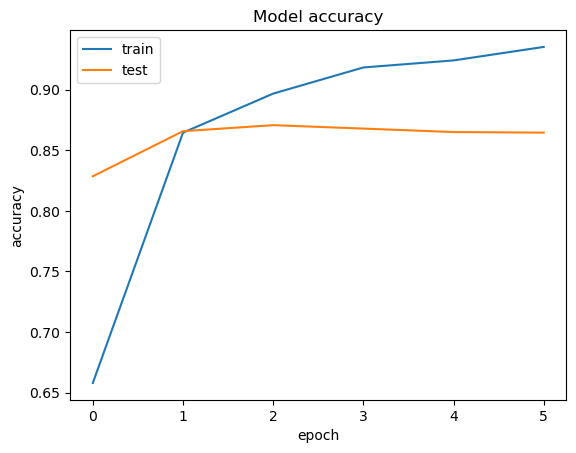

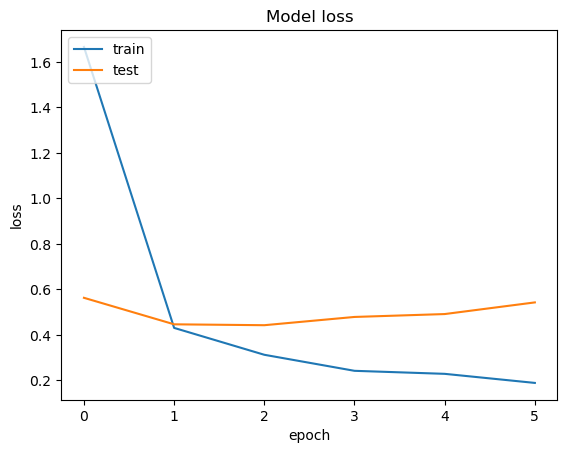

132/132 [==============================] - 1s 4ms/step - loss: 0.4621 - accuracy: 0.8682 - f1_score: 0.8682
[0.4621005952358246, 0.8681714534759521, 0.8681714534759521]
Test Loss: 0.4621005952358246
Test Accuracy: 0.8681714534759521
Test micro-f1 Score: 0.8681714534759521


In [ ]:
model = create_custom_conv_net(img_rows,img_cols,3)
categorical_accuracy = keras.metrics.categorical_accuracy
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/customcnn_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_cnn = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_rgb_cnn)
eval_model(model, model_path, rgb_test)

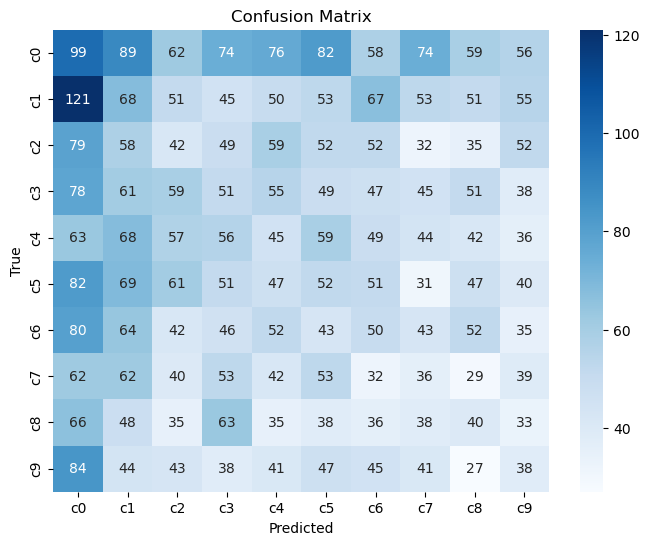

In [ ]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**DenseNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121

def DenseNet_Model(img_rows, img_cols, color_type):
    # Load the DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, color_type))

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create your model
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(NUMBER_CLASSES, activation='softmax'))

    return model

config = tf.compat.v1.ConfigProto()
config.allow_soft_placement = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Epoch 1/10
421/422 [============================>.] - ETA: 0s - loss: 1.7882 - accuracy: 0.4032 - f1_score: 0.5141
Epoch 1: val_loss improved from inf to 1.40268, saving model to ./saved_models\densenet_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


422/422 [==============================] - 58s 126ms/step - loss: 1.7874 - accuracy: 0.4032 - f1_score: 0.5139 - val_loss: 1.4027 - val_accuracy: 0.5248 - val_f1_score: 0.5248
Epoch 2/10
421/422 [============================>.] - ETA: 0s - loss: 1.2608 - accuracy: 0.5799 - f1_score: 0.5799
Epoch 2: val_loss improved from 1.40268 to 1.03092, saving model to ./saved_models\densenet_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


422/422 [==============================] - 53s 125ms/step - loss: 1.2610 - accuracy: 0.5800 - f1_score: 0.5800 - val_loss: 1.0309 - val_accuracy: 0.6675 - val_f1_score: 0.6675
Epoch 3/10
421/422 [============================>.] - ETA: 0s - loss: 1.1054 - accuracy: 0.6306 - f1_score: 0.6306
Epoch 3: val_loss improved from 1.03092 to 0.98421, saving model to ./saved_models\densenet_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


422/422 [==============================] - 56s 134ms/step - loss: 1.1051 - accuracy: 0.6307 - f1_score: 0.6307 - val_loss: 0.9842 - val_accuracy: 0.6666 - val_f1_score: 0.6666
Epoch 4/10
421/422 [============================>.] - ETA: 0s - loss: 1.0266 - accuracy: 0.6607 - f1_score: 0.6607
Epoch 4: val_loss improved from 0.98421 to 0.89814, saving model to ./saved_models\densenet_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


422/422 [==============================] - 57s 136ms/step - loss: 1.0266 - accuracy: 0.6606 - f1_score: 0.6606 - val_loss: 0.8981 - val_accuracy: 0.7150 - val_f1_score: 0.7150
Epoch 5/10
421/422 [============================>.] - ETA: 0s - loss: 1.0003 - accuracy: 0.6703 - f1_score: 0.6703
Epoch 5: val_loss improved from 0.89814 to 0.85276, saving model to ./saved_models\densenet_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


422/422 [==============================] - 49s 116ms/step - loss: 1.0001 - accuracy: 0.6705 - f1_score: 0.6705 - val_loss: 0.8528 - val_accuracy: 0.7444 - val_f1_score: 0.7444
Epoch 6/10
422/422 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.6806 - f1_score: 0.6806
Epoch 6: val_loss did not improve from 0.85276
422/422 [==============================] - 15s 35ms/step - loss: 0.9543 - accuracy: 0.6806 - f1_score: 0.6806 - val_loss: 0.8721 - val_accuracy: 0.7005 - val_f1_score: 0.7005
Epoch 7/10
421/422 [============================>.] - ETA: 0s - loss: 0.9033 - accuracy: 0.7010 - f1_score: 0.7010
Epoch 7: val_loss improved from 0.85276 to 0.82226, saving model to ./saved_models\densenet_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


422/422 [==============================] - 52s 123ms/step - loss: 0.9034 - accuracy: 0.7010 - f1_score: 0.7010 - val_loss: 0.8223 - val_accuracy: 0.7422 - val_f1_score: 0.7422
Epoch 8/10
421/422 [============================>.] - ETA: 0s - loss: 0.8912 - accuracy: 0.7051 - f1_score: 0.7051
Epoch 8: val_loss did not improve from 0.82226
422/422 [==============================] - 16s 38ms/step - loss: 0.8905 - accuracy: 0.7053 - f1_score: 0.7053 - val_loss: 0.8606 - val_accuracy: 0.7166 - val_f1_score: 0.7166
Epoch 9/10
421/422 [============================>.] - ETA: 0s - loss: 0.8755 - accuracy: 0.7092 - f1_score: 0.7092
Epoch 9: val_loss improved from 0.82226 to 0.76611, saving model to ./saved_models\densenet_best_grayscale


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


422/422 [==============================] - 56s 134ms/step - loss: 0.8761 - accuracy: 0.7091 - f1_score: 0.7091 - val_loss: 0.7661 - val_accuracy: 0.7617 - val_f1_score: 0.7617
Epoch 10/10
422/422 [==============================] - ETA: 0s - loss: 0.8695 - accuracy: 0.7148 - f1_score: 0.7148
Epoch 10: val_loss did not improve from 0.76611
422/422 [==============================] - 15s 35ms/step - loss: 0.8695 - accuracy: 0.7148 - f1_score: 0.7148 - val_loss: 0.8259 - val_accuracy: 0.7631 - val_f1_score: 0.7631


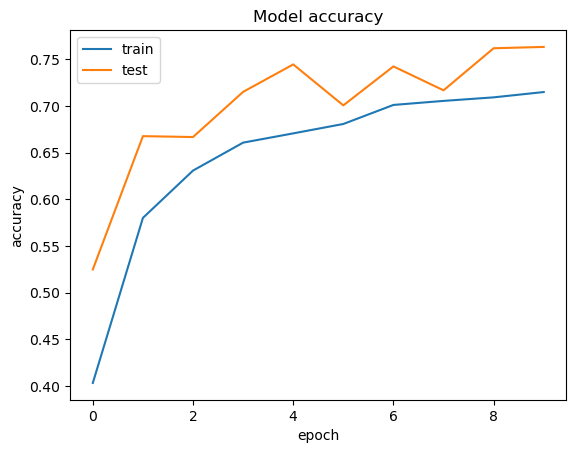

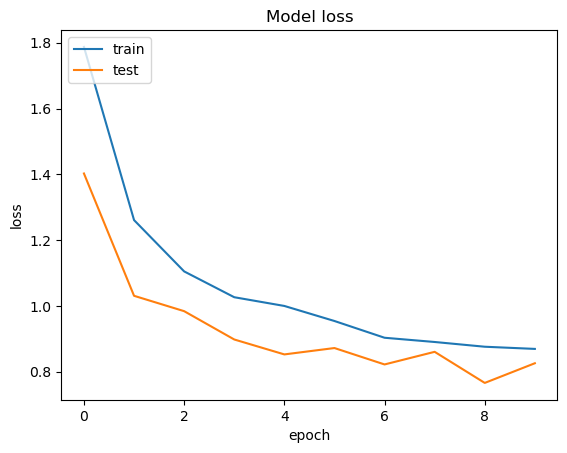

132/132 [==============================] - 4s 28ms/step - loss: 0.7978 - accuracy: 0.7434 - f1_score: 0.7434
[0.7978087663650513, 0.7433611750602722, 0.7433611750602722]
Test Loss: 0.7978087663650513
Test Accuracy: 0.7433611750602722
Test micro-f1 Score: 0.7433611750602722


In [ ]:
model = DenseNet_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/densenet_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale3_dense = model.fit_generator(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_grayscale3_dense)
eval_model(model, model_path, grayscale3_test)

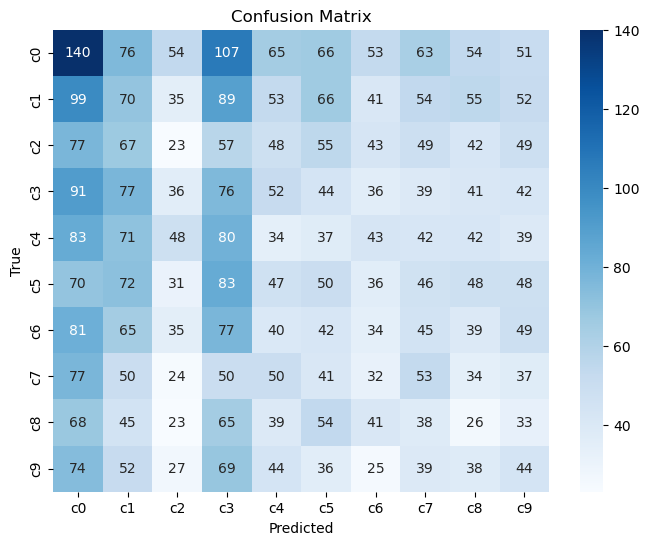

In [ ]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
421/422 [============================>.] - ETA: 0s - loss: 1.7601 - accuracy: 0.4170 - f1_score: 0.4949
Epoch 1: val_loss improved from inf to 1.21186, saving model to ./saved_models\densenet_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


422/422 [==============================] - 59s 130ms/step - loss: 1.7595 - accuracy: 0.4175 - f1_score: 0.4951 - val_loss: 1.2119 - val_accuracy: 0.6002 - val_f1_score: 0.6002
Epoch 2/10
422/422 [==============================] - ETA: 0s - loss: 1.2130 - accuracy: 0.5985 - f1_score: 0.5985
Epoch 2: val_loss improved from 1.21186 to 0.89268, saving model to ./saved_models\densenet_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


422/422 [==============================] - 54s 128ms/step - loss: 1.2130 - accuracy: 0.5985 - f1_score: 0.5985 - val_loss: 0.8927 - val_accuracy: 0.7143 - val_f1_score: 0.7143
Epoch 3/10
422/422 [==============================] - ETA: 0s - loss: 1.0501 - accuracy: 0.6534 - f1_score: 0.6534
Epoch 3: val_loss did not improve from 0.89268
422/422 [==============================] - 15s 36ms/step - loss: 1.0501 - accuracy: 0.6534 - f1_score: 0.6534 - val_loss: 0.9388 - val_accuracy: 0.6969 - val_f1_score: 0.6969
Epoch 4/10
422/422 [==============================] - ETA: 0s - loss: 0.9936 - accuracy: 0.6706 - f1_score: 0.6706
Epoch 4: val_loss improved from 0.89268 to 0.84634, saving model to ./saved_models\densenet_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


422/422 [==============================] - 51s 120ms/step - loss: 0.9936 - accuracy: 0.6706 - f1_score: 0.6706 - val_loss: 0.8463 - val_accuracy: 0.7209 - val_f1_score: 0.7209
Epoch 5/10
421/422 [============================>.] - ETA: 0s - loss: 0.9468 - accuracy: 0.6896 - f1_score: 0.6896
Epoch 5: val_loss improved from 0.84634 to 0.82361, saving model to ./saved_models\densenet_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


422/422 [==============================] - 56s 133ms/step - loss: 0.9473 - accuracy: 0.6895 - f1_score: 0.6895 - val_loss: 0.8236 - val_accuracy: 0.7456 - val_f1_score: 0.7456
Epoch 6/10
421/422 [============================>.] - ETA: 0s - loss: 0.9239 - accuracy: 0.6938 - f1_score: 0.6938
Epoch 6: val_loss did not improve from 0.82361
422/422 [==============================] - 17s 39ms/step - loss: 0.9240 - accuracy: 0.6939 - f1_score: 0.6939 - val_loss: 0.9244 - val_accuracy: 0.6929 - val_f1_score: 0.6929
Epoch 7/10
422/422 [==============================] - ETA: 0s - loss: 0.9216 - accuracy: 0.6932 - f1_score: 0.6932
Epoch 7: val_loss improved from 0.82361 to 0.81985, saving model to ./saved_models\densenet_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


422/422 [==============================] - 55s 129ms/step - loss: 0.9216 - accuracy: 0.6932 - f1_score: 0.6932 - val_loss: 0.8198 - val_accuracy: 0.7396 - val_f1_score: 0.7396
Epoch 8/10
421/422 [============================>.] - ETA: 0s - loss: 0.8903 - accuracy: 0.7060 - f1_score: 0.7060
Epoch 8: val_loss did not improve from 0.81985
422/422 [==============================] - 15s 36ms/step - loss: 0.8909 - accuracy: 0.7058 - f1_score: 0.7058 - val_loss: 1.0156 - val_accuracy: 0.6747 - val_f1_score: 0.6747
Epoch 9/10
421/422 [============================>.] - ETA: 0s - loss: 0.8866 - accuracy: 0.7111 - f1_score: 0.7111
Epoch 9: val_loss improved from 0.81985 to 0.79564, saving model to ./saved_models\densenet_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


422/422 [==============================] - 50s 118ms/step - loss: 0.8867 - accuracy: 0.7112 - f1_score: 0.7112 - val_loss: 0.7956 - val_accuracy: 0.7484 - val_f1_score: 0.7484
Epoch 10/10
421/422 [============================>.] - ETA: 0s - loss: 0.8665 - accuracy: 0.7188 - f1_score: 0.7188
Epoch 10: val_loss did not improve from 0.79564
422/422 [==============================] - 15s 36ms/step - loss: 0.8660 - accuracy: 0.7190 - f1_score: 0.7190 - val_loss: 0.8102 - val_accuracy: 0.7503 - val_f1_score: 0.7503


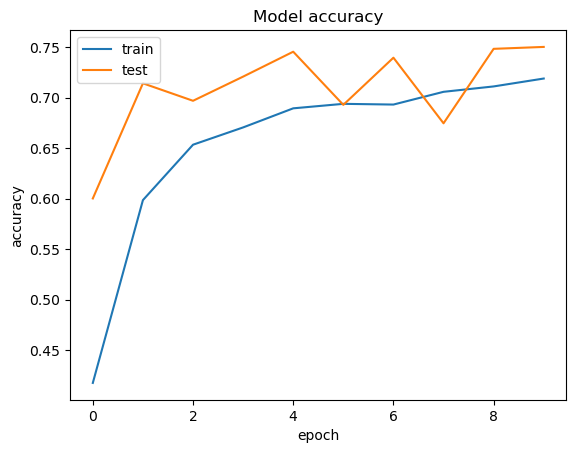

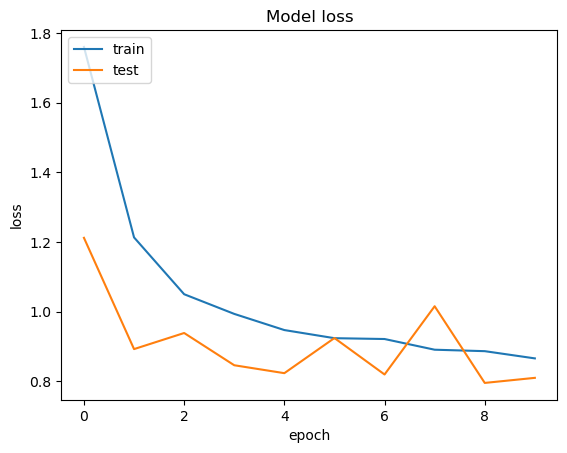

132/132 [==============================] - 4s 30ms/step - loss: 0.8436 - accuracy: 0.7320 - f1_score: 0.7320
[0.843619704246521, 0.7319802641868591, 0.7319802641868591]
Test Loss: 0.843619704246521
Test Accuracy: 0.7319802641868591
Test micro-f1 Score: 0.7319802641868591


In [ ]:
model = DenseNet_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/densenet_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_dense = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_rgb_dense)
eval_model(model, model_path, rgb_test)

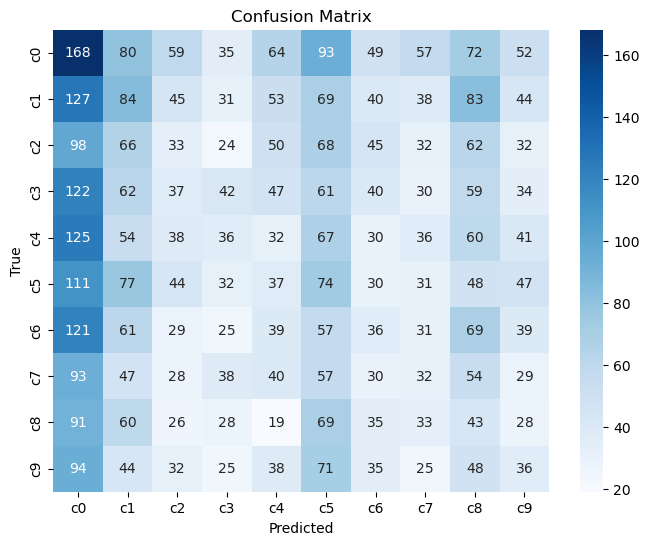

In [ ]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**EfficientNet**

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Input

def EfficientNet_Model(img_rows, img_cols, color_type):
    inputs = Input(shape=(img_rows, img_cols, color_type))
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Change the output layer to match the number of classes
    output = Dense(units=NUMBER_CLASSES, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

Epoch 1/10
422/422 [==============================] - 23s 35ms/step - loss: 1.8049 - accuracy: 0.4009 - f1_score: 0.4443 - val_loss: 1.0916 - val_accuracy: 0.6173 - val_f1_score: 0.6173
Epoch 2/10
422/422 [==============================] - 13s 31ms/step - loss: 1.2673 - accuracy: 0.5591 - f1_score: 0.5591 - val_loss: 0.8748 - val_accuracy: 0.7029 - val_f1_score: 0.7029
Epoch 3/10
422/422 [==============================] - 13s 31ms/step - loss: 1.0863 - accuracy: 0.6298 - f1_score: 0.6298 - val_loss: 0.7446 - val_accuracy: 0.7605 - val_f1_score: 0.7605
Epoch 4/10
422/422 [==============================] - 14s 32ms/step - loss: 1.0036 - accuracy: 0.6579 - f1_score: 0.6579 - val_loss: 0.7386 - val_accuracy: 0.7759 - val_f1_score: 0.7759
Epoch 5/10
422/422 [==============================] - 13s 32ms/step - loss: 0.9348 - accuracy: 0.6805 - f1_score: 0.6805 - val_loss: 0.6727 - val_accuracy: 0.7745 - val_f1_score: 0.7745
Epoch 6/10
422/422 [==============================] - 12s 29ms/step - 

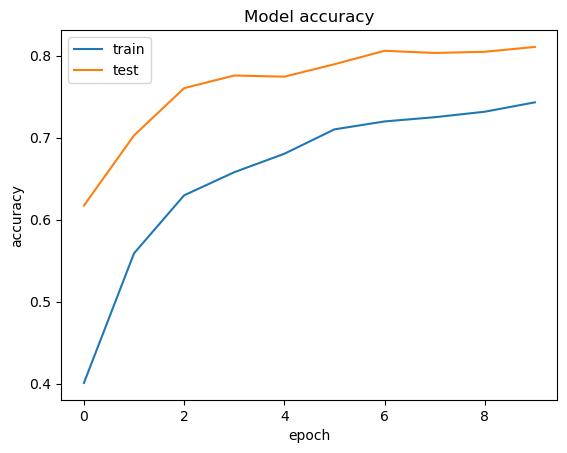

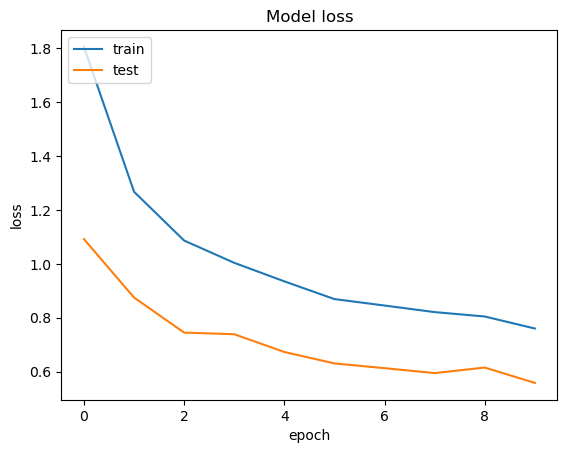

132/132 [==============================] - 3s 23ms/step - loss: 1.1309 - accuracy: 0.6176 - f1_score: 0.6176
[1.1309351921081543, 0.6176024079322815, 0.6176024079322815]
Test Loss: 1.1309351921081543
Test Accuracy: 0.6176024079322815
Test micro-f1 Score: 0.6176024079322815


In [ ]:
model = EfficientNet_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/efficientnet_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale3_enet = model.fit_generator(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        #callbacks=callbacks,
                                              verbose=1)
plot_train_history(history_grayscale3_enet)
eval_model(model, model_path, grayscale3_test)

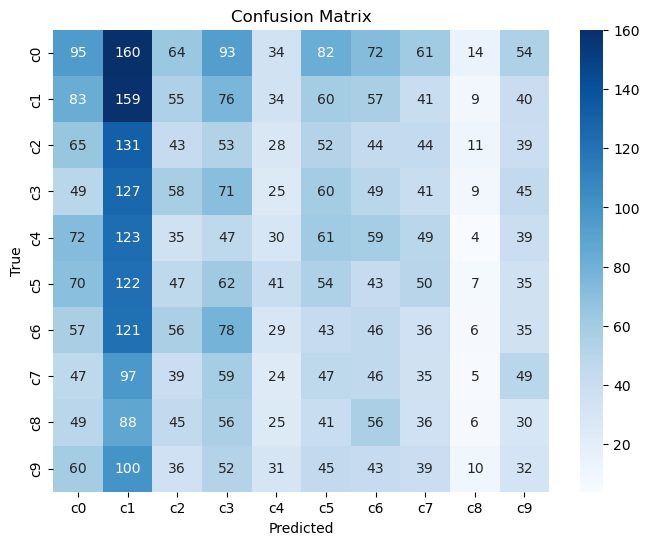

In [ ]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
422/422 [==============================] - 21s 33ms/step - loss: 1.7923 - accuracy: 0.4051 - f1_score: 0.4557 - val_loss: 0.9753 - val_accuracy: 0.6806 - val_f1_score: 0.6806
Epoch 2/10
422/422 [==============================] - 12s 28ms/step - loss: 1.1886 - accuracy: 0.5927 - f1_score: 0.5927 - val_loss: 0.8233 - val_accuracy: 0.7327 - val_f1_score: 0.7327
Epoch 3/10
422/422 [==============================] - 12s 28ms/step - loss: 1.0203 - accuracy: 0.6511 - f1_score: 0.6511 - val_loss: 0.6618 - val_accuracy: 0.7899 - val_f1_score: 0.7899
Epoch 4/10
422/422 [==============================] - 12s 29ms/step - loss: 0.9075 - accuracy: 0.6925 - f1_score: 0.6925 - val_loss: 0.6443 - val_accuracy: 0.7840 - val_f1_score: 0.7840
Epoch 5/10
422/422 [==============================] - 12s 29ms/step - loss: 0.8519 - accuracy: 0.7145 - f1_score: 0.7145 - val_loss: 0.5641 - val_accuracy: 0.8101 - val_f1_score: 0.8101
Epoch 6/10
422/422 [==============================] - 12s 29ms/step - 

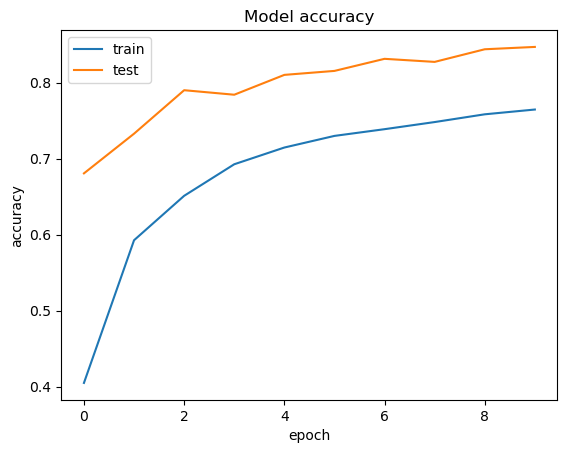

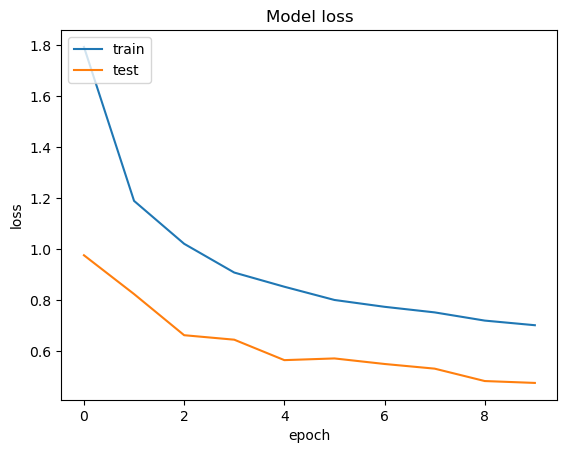

132/132 [==============================] - 3s 23ms/step - loss: 1.0903 - accuracy: 0.6813 - f1_score: 0.6813
[1.0903106927871704, 0.6813353300094604, 0.6813353300094604]
Test Loss: 1.0903106927871704
Test Accuracy: 0.6813353300094604
Test micro-f1 Score: 0.6813353300094604


In [ ]:
model = EfficientNet_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/efficientnet_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_enet = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        #callbacks=callbacks,
                                       verbose=1)
plot_train_history(history_rgb_enet)
eval_model(model, model_path, rgb_test)

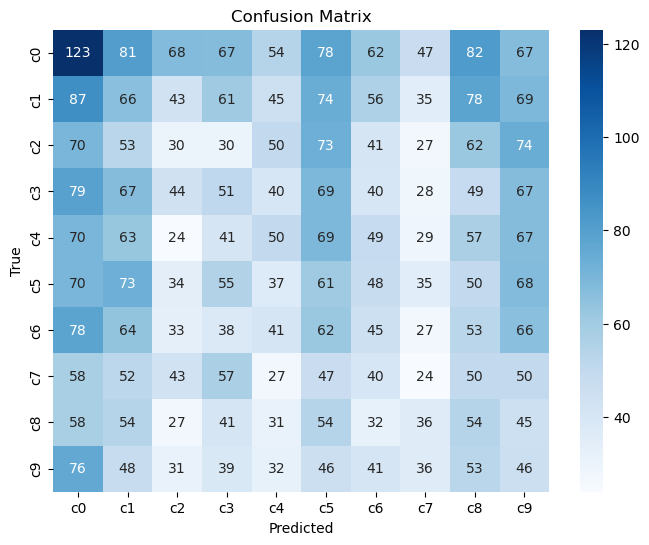

In [ ]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**ResNet50**

In [ ]:
from keras.applications.resnet import ResNet50

def ResNet50_Model(img_rows, img_cols, color_type=3):
    resnet_model = ResNet50(input_shape=(img_rows, img_cols, color_type), weights="imagenet", include_top=False)
    for layer in resnet_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(resnet_model.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)

    # Change the output layer to match the number of classes
    predictions = Dense(NUMBER_CLASSES, activation='softmax')(x)

    model = Model(inputs=resnet_model.input, outputs=predictions)
    return model

In [ ]:
model = ResNet50_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/resnet50_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale3_resnet = model.fit_generator(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        #callbacks=callbacks,
                                                verbose=1)
plot_train_history(history_grayscale3_resnet)
eval_model(model, model_path, grayscale3_test)

In [ ]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
420/422 [============================>.] - ETA: 0s - loss: 1.8419 - accuracy: 0.3994 - f1_score: 0.4703
Epoch 1: val_loss improved from inf to 1.06716, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 30s 64ms/step - loss: 1.8394 - accuracy: 0.4003 - f1_score: 0.4707 - val_loss: 1.0672 - val_accuracy: 0.6796 - val_f1_score: 0.6796
Epoch 2/10
420/422 [============================>.] - ETA: 0s - loss: 1.1255 - accuracy: 0.6207 - f1_score: 0.6207
Epoch 2: val_loss improved from 1.06716 to 0.72517, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 24s 57ms/step - loss: 1.1243 - accuracy: 0.6209 - f1_score: 0.6209 - val_loss: 0.7252 - val_accuracy: 0.7761 - val_f1_score: 0.7761
Epoch 3/10
422/422 [==============================] - ETA: 0s - loss: 0.8927 - accuracy: 0.7007 - f1_score: 0.7007
Epoch 3: val_loss improved from 0.72517 to 0.61299, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 23s 54ms/step - loss: 0.8927 - accuracy: 0.7007 - f1_score: 0.7007 - val_loss: 0.6130 - val_accuracy: 0.8219 - val_f1_score: 0.8219
Epoch 4/10
422/422 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.7508 - f1_score: 0.7508
Epoch 4: val_loss improved from 0.61299 to 0.54824, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 24s 56ms/step - loss: 0.7466 - accuracy: 0.7508 - f1_score: 0.7508 - val_loss: 0.5482 - val_accuracy: 0.8307 - val_f1_score: 0.8307
Epoch 5/10
421/422 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.7850 - f1_score: 0.7850
Epoch 5: val_loss improved from 0.54824 to 0.49924, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 26s 62ms/step - loss: 0.6556 - accuracy: 0.7852 - f1_score: 0.7852 - val_loss: 0.4992 - val_accuracy: 0.8501 - val_f1_score: 0.8501
Epoch 6/10
420/422 [============================>.] - ETA: 0s - loss: 0.5967 - accuracy: 0.8030 - f1_score: 0.8030
Epoch 6: val_loss improved from 0.49924 to 0.47970, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 24s 57ms/step - loss: 0.5967 - accuracy: 0.8030 - f1_score: 0.8030 - val_loss: 0.4797 - val_accuracy: 0.8549 - val_f1_score: 0.8549
Epoch 7/10
422/422 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.8152 - f1_score: 0.8152
Epoch 7: val_loss improved from 0.47970 to 0.46165, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 24s 57ms/step - loss: 0.5445 - accuracy: 0.8152 - f1_score: 0.8152 - val_loss: 0.4617 - val_accuracy: 0.8587 - val_f1_score: 0.8587
Epoch 8/10
421/422 [============================>.] - ETA: 0s - loss: 0.5060 - accuracy: 0.8305 - f1_score: 0.8305
Epoch 8: val_loss improved from 0.46165 to 0.45696, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 25s 58ms/step - loss: 0.5064 - accuracy: 0.8305 - f1_score: 0.8305 - val_loss: 0.4570 - val_accuracy: 0.8618 - val_f1_score: 0.8618
Epoch 9/10
421/422 [============================>.] - ETA: 0s - loss: 0.4768 - accuracy: 0.8415 - f1_score: 0.8415
Epoch 9: val_loss improved from 0.45696 to 0.44397, saving model to ./saved_models\resnet50_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


422/422 [==============================] - 24s 57ms/step - loss: 0.4768 - accuracy: 0.8416 - f1_score: 0.8416 - val_loss: 0.4440 - val_accuracy: 0.8667 - val_f1_score: 0.8667
Epoch 10/10
420/422 [============================>.] - ETA: 0s - loss: 0.4457 - accuracy: 0.8506 - f1_score: 0.8506
Epoch 10: val_loss did not improve from 0.44397
422/422 [==============================] - 10s 23ms/step - loss: 0.4461 - accuracy: 0.8505 - f1_score: 0.8505 - val_loss: 0.4648 - val_accuracy: 0.8568 - val_f1_score: 0.8568


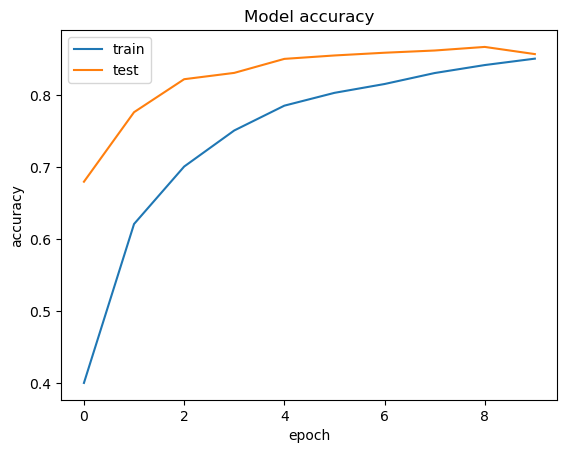

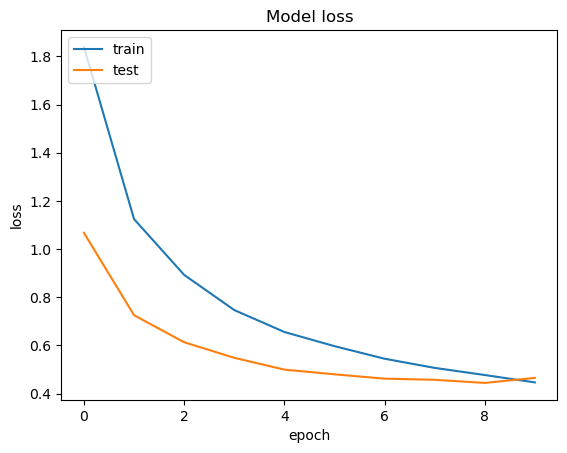

132/132 [==============================] - 2s 19ms/step - loss: 0.4400 - accuracy: 0.8640 - f1_score: 0.8640
[0.43996942043304443, 0.8639984726905823, 0.8639984726905823]
Test Loss: 0.43996942043304443
Test Accuracy: 0.8639984726905823
Test micro-f1 Score: 0.8639984726905823


In [ ]:
model = ResNet50_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/resnet50_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_resnet = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,
                                         verbose=1)
plot_train_history(history_rgb_resnet)
eval_model(model, model_path, rgb_test)

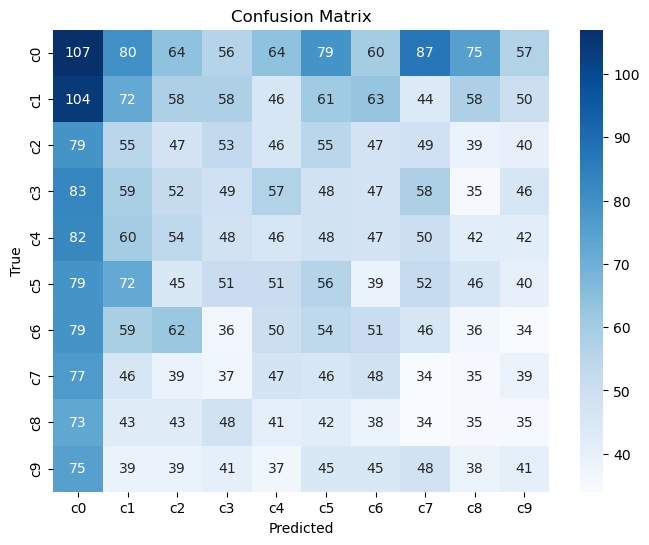

In [ ]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**VGG-16**

In [ ]:
def VGG16_Model(img_rows, img_cols, color_type=3):
    """
    Architecture and adaptation of the VGG16 for our project
    """
    # Remove fully connected layer and replace
    vgg16_model = VGG16(input_shape=(img_rows, img_cols, color_type), weights="imagenet", include_top=False)
    for layer in vgg16_model.layers:
        layer.trainable = False

    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUMBER_CLASSES, activation = 'softmax')(x) # add dense layer with 10 neurons and activation softmax
    model = Model(vgg16_model.input,predictions)
    return model

In [ ]:
model = VGG16_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/vgg16_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale3_vgg16 = model.fit_generator(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        #callbacks=callbacks,
                                               verbose=1)
plot_train_history(history_grayscale3_vgg16)
eval_model(model, model_path, grayscale3_test)

In [ ]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
420/422 [============================>.] - ETA: 0s - loss: 2.0049 - accuracy: 0.6863 - f1_score: 0.7287
Epoch 1: val_loss improved from inf to 0.78125, saving model to ./saved_models\vgg16_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


422/422 [==============================] - 15s 31ms/step - loss: 1.9987 - accuracy: 0.6867 - f1_score: 0.7289 - val_loss: 0.7812 - val_accuracy: 0.8027 - val_f1_score: 0.8027
Epoch 2/10
421/422 [============================>.] - ETA: 0s - loss: 0.3891 - accuracy: 0.8821 - f1_score: 0.8821
Epoch 2: val_loss improved from 0.78125 to 0.64829, saving model to ./saved_models\vgg16_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


422/422 [==============================] - 12s 27ms/step - loss: 0.3890 - accuracy: 0.8822 - f1_score: 0.8822 - val_loss: 0.6483 - val_accuracy: 0.8425 - val_f1_score: 0.8425
Epoch 3/10
421/422 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9330 - f1_score: 0.9330
Epoch 3: val_loss improved from 0.64829 to 0.56520, saving model to ./saved_models\vgg16_best_rgb


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


422/422 [==============================] - 19s 44ms/step - loss: 0.2105 - accuracy: 0.9330 - f1_score: 0.9330 - val_loss: 0.5652 - val_accuracy: 0.8719 - val_f1_score: 0.8719
Epoch 4/10
422/422 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9554 - f1_score: 0.9554
Epoch 4: val_loss did not improve from 0.56520
422/422 [==============================] - 14s 33ms/step - loss: 0.1368 - accuracy: 0.9554 - f1_score: 0.9554 - val_loss: 0.6142 - val_accuracy: 0.8708 - val_f1_score: 0.8708
Epoch 5/10
421/422 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9578 - f1_score: 0.9578
Epoch 5: val_loss did not improve from 0.56520
422/422 [==============================] - 12s 29ms/step - loss: 0.1313 - accuracy: 0.9576 - f1_score: 0.9576 - val_loss: 0.7916 - val_accuracy: 0.8423 - val_f1_score: 0.8423
Epoch 6/10
420/422 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9478 - f1_score: 0.9478
Epoch 6: val_loss did not improve fr

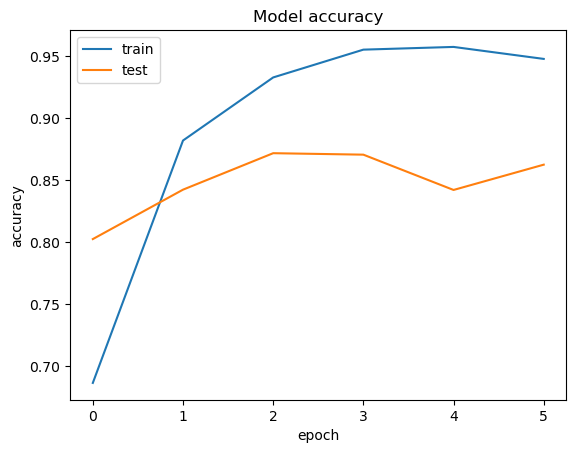

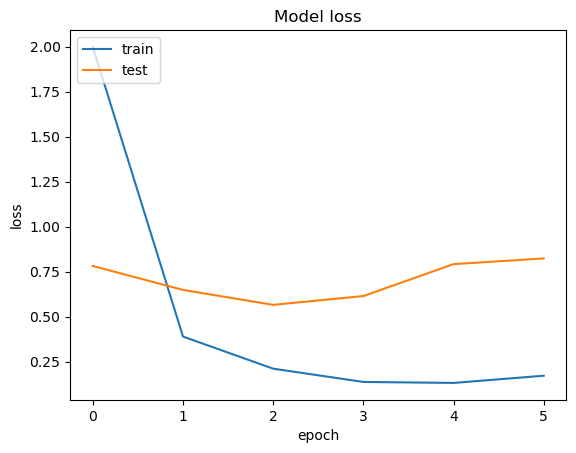

132/132 [==============================] - 3s 25ms/step - loss: 0.6471 - accuracy: 0.8564 - f1_score: 0.8564
[0.6471423506736755, 0.8564112186431885, 0.8564112186431885]
Test Loss: 0.6471423506736755
Test Accuracy: 0.8564112186431885
Test micro-f1 Score: 0.8564112186431885


In [ ]:
model = VGG16_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/vgg16_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_vgg16 = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,
                                        verbose=1)
plot_train_history(history_rgb_vgg16)
eval_model(model, model_path, rgb_test)

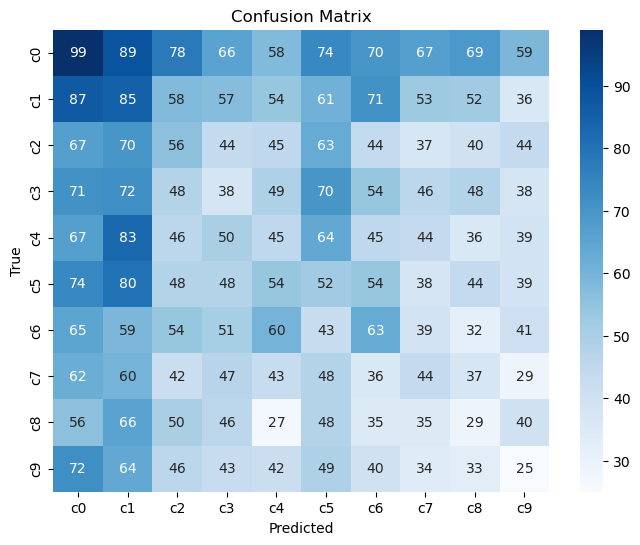

In [ ]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

# Submission

In [ ]:
def create_submission(predictions, test_id):
    """
    Submission function for participating to the competition
    """
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)

    now = datetime.datetime.now()

    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}".format(str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')

    result.to_csv(sub_file, index=False)

    return sub_file

In [ ]:
submission_test, submission_targets = read_and_normalize_sampled_test_data(size=79726,img_rows=img_rows, img_cols=img_cols)

In [ ]:
submission_test_grayscale, submission_targets_grayscale = read_and_normalize_sampled_test_data(size=79726,img_rows=img_rows, \
                                                                                     img_cols=img_cols, color_type=1)
submission_test_grayscale = np.repeat(submission_test_grayscale, 3, axis=-1)

In [ ]:
def Ensemble_Model_Predictions(models_list, test_files, test_targets):
    individual_predictions = []
    for model in models_list:
        pred = model.predict(test_files, batch_size=batch_size, verbose=1)
        individual_predictions.append(pred)
        create_submission(pred, test_targets)
    ensemble_predictions = tf.stack(individual_predictions, axis=0)
    ensemble_predictions = tf.reduce_mean(ensemble_predictions, axis=0)
    return ensemble_predictions

In [ ]:
from tensorflow.keras.models import load_model
# Example usage:
# Paths to the pre-trained model files
cnn_path = './saved_models/customcnn_best_grayscale'
densenet_path = './saved_models/densenet_best_grayscale'
enet_path = './saved_models/efficientnet_best_grayscale'
resnet_path = './saved_models/resnet50_best_grayscale'
vgg_path = './saved_models/vgg16_best_grayscale'

model_paths = [cnn_path, densenet_path, enet_path, resnet_path, vgg_path]
models = [load_model(path) for path in model_paths]

# Create an instance of the ensemble model
ensemble_model_preds_grayscale = Ensemble_Model_Predictions(models, submission_test_grayscale, submission_targets_grayscale)

In [ ]:
create_submission(ensemble_model_preds_grayscale, submission_targets_grayscale)

In [ ]:
from tensorflow.keras.models import load_model
# Example usage:
# Paths to the pre-trained model files
cnn_path = './saved_models/customcnn_best_rgb'
densenet_path = './saved_models/densenet_best_rgb'
enet_path = './saved_models/efficientnet_best_rgb'
resnet_path = './saved_models/resnet50_best_rgb'
vgg_path = './saved_models/vgg16_best_rgb'

model_paths = [cnn_path, densenet_path, enet_path, resnet_path, vgg_path]
models = [load_model(path) for path in model_paths]

# Create an instance of the ensemble model
ensemble_model_preds = Ensemble_Model_Predictions(models, submission_test, submission_targets)

ValueError: Unable to create a Keras model from SavedModel at ./saved_models/efficientnet_best_rgb. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

In [ ]:
create_submission(ensemble_model_preds, submission_targets)